# Homicidios en Colombia 2018
## Camilo Esteban Ruiz

El siguiente es un análisis de la base de datos de homicidios cometidos en Colombia en el año 2018.

La base de datos es tomada de https://www.datos.gov.co/Seguridad-y-Defensa/Homicidios-2018/pz7x-mkbs, y conectada a Google BigQuery on el fin de almacenar los datos y a través de sentencias SQL, consultar o modificar la base de datos.

In [125]:
#Librerias

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.pyplot import plot
import seaborn as sn
%matplotlib inline 

Para acceder a la base de datos almacenada en Big Query, es necesario hacer la conexión directa al proyecto.

In [126]:
# Set your own project id here
PROJECT_ID = 'prueba-data-287014'
from google.cloud import bigquery
from bq_helper import BigQueryHelper

client = bigquery.Client(project=PROJECT_ID)

dataset_ref = client.dataset('Homicidios_2018', project=PROJECT_ID)

# Make an API request to fetch the dataset
dataset = client.get_dataset(dataset_ref)

Una vez hecho el enlace, se puede acceder directamente a la tabla para iniciar la visualización de los datos.

In [127]:
tables = list(client.list_tables(dataset))

h_df = client.list_rows(tables[1], max_results=5).to_dataframe()
h_df.head()

,Fecha,Departamento,Municipio,Dia,Hora,Barrio,Zona,Clase_de_sitio,Arma,Movil_agresor,Movil_victima,Edad,Sexo,Estado_civil,Pais_de_nacimiento,Clase_de_empleado,Profesion,Esolaridad,Codigo,Cantidad
0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"12,667"
1,06/08/2018 12:00:00 AM,ANTIOQUIA,MEDELLÍN (CT),Lunes,14:20:00,KENNEDY C-6,URBANA,CASAS DE HABITACION,ARMA DE FUEGO,A PIE,A PIE,28,MASCULINO,UNION LIBRE,COLOMBIA,INDEPENDIENTE,-,SECUNDARIA,"5,001,000",1
2,12/03/2018 12:00:00 AM,ANTIOQUIA,MEDELLÍN (CT),Lunes,23:00:00,CORAZON DE JESUS C-10,URBANA,VIAS PUBLICAS,ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,49,MASCULINO,SOLTERO,COLOMBIA,DESEMPLEADO,-,ANALFABETA,"5,001,000",1
3,01/01/2018 12:00:00 AM,ANTIOQUIA,MEDELLÍN (CT),Lunes,10:39:00,POPULAR 1 C-1,URBANA,VIAS PUBLICAS,ARMA DE FUEGO,A PIE,A PIE,36,MASCULINO,CASADO,COLOMBIA,EMPLEADO PARTICULAR,-,SECUNDARIA,"5,001,000",1
4,09/07/2018 12:00:00 AM,ANTIOQUIA,MEDELLÍN (CT),Lunes,16:23:00,LA HONDONADA C-16,URBANA,VIAS PUBLICAS,ARMA DE FUEGO,A PIE,A PIE,31,MASCULINO,SOLTERO,COLOMBIA,DESEMPLEADO,-,SECUNDARIA,"5,001,000",1


A través de SQL se inicia el proceso exploratorio. Primero se descartan dos filas que no contienen información alguna, una esta totalmente vacia, y la segunda, repite los headers de cada una de las columnas.

In [128]:
#Query SQL
query = "SELECT * FROM `Homicidios_2018.Homicidios20181` WHERE NOT (Fecha = 'Fecha' OR Fecha = 'None')";
query_job1 = client.query(query)
df = query_job1.to_dataframe()
print(df.head())

                    Fecha Departamento      Municipio    Dia      Hora  \
0  06/08/2018 12:00:00 AM    ANTIOQUIA  MEDELLÍN (CT)  Lunes  14:20:00   
1  12/03/2018 12:00:00 AM    ANTIOQUIA  MEDELLÍN (CT)  Lunes  23:00:00   
2  01/01/2018 12:00:00 AM    ANTIOQUIA  MEDELLÍN (CT)  Lunes  10:39:00   
3  09/07/2018 12:00:00 AM    ANTIOQUIA  MEDELLÍN (CT)  Lunes  16:23:00   
4  02/04/2018 12:00:00 AM    ANTIOQUIA  MEDELLÍN (CT)  Lunes   0:05:00   

                  Barrio    Zona       Clase_de_sitio  \
0            KENNEDY C-6  URBANA  CASAS DE HABITACION   
1  CORAZON DE JESUS C-10  URBANA        VIAS PUBLICAS   
2          POPULAR 1 C-1  URBANA        VIAS PUBLICAS   
3      LA HONDONADA C-16  URBANA        VIAS PUBLICAS   
4              ALTAVISTA  URBANA        VIAS PUBLICAS   

                          Arma Movil_agresor Movil_victima Edad       Sexo  \
0                ARMA DE FUEGO         A PIE         A PIE   28  MASCULINO   
1  ARMA BLANCA / CORTOPUNZANTE         A PIE         A P

Se destacan cierttos detalles, uno de ellos es el formato de la columna de Fecha que resulta ser erroneo paa su manipulación con Pandas. Adicional a estto, el campo de FFecha también incluye un valor de hora erroneo que no corresponde al encontrado en la columna Hora.

In [129]:
#Query SQL
query = "SELECT count(*) FROM `Homicidios_2018.Homicidios20181`";
query_job1 = client.query(query)

print(query_job1.to_dataframe().head())

    f0_
0  4966


In [130]:
#Query SQL
query = "SELECT Fecha FROM `Homicidios_2018.Homicidios20181` WHERE NOT (Fecha = 'Fecha' OR Fecha = 'None')";
query_job1 = client.query(query)

print(query_job1.to_dataframe().head())

                    Fecha
0  06/08/2018 12:00:00 AM
1  12/03/2018 12:00:00 AM
2  01/01/2018 12:00:00 AM
3  09/07/2018 12:00:00 AM
4  02/04/2018 12:00:00 AM


Haciendo el análisis, se puede extraer el hecho que no hay información de homicidios para todos los días del año.

In [131]:
#Query SQL
query = "SELECT count(DISTINCT Fecha) FROM `Homicidios_2018.Homicidios20181` WHERE NOT (Fecha = 'Fecha' OR Fecha = 'None')";
query_job1 = client.query(query)

print(query_job1.to_dataframe().head())

   f0_
0  144


A simple vista se puede notar que varios campos en la columna Profesión, tienen como valor '-', lo que se asume como infomaicón no conocida o incompleta. Usando un SQL, se identifica cuántas filas cumplen con esa condición. AL final se arroja un valor de 4838 celdas sin información de Profesión, por lo tanto, debe se descartada. 

In [132]:
#Query SQL
query = "SELECT count(*) FROM `Homicidios_2018.Homicidios20181` WHERE Profesion = '-' GROUP BY Profesion ";
query_job1 = client.query(query)
print(query_job1.to_dataframe())

    f0_
0  4838


La tabla también inluye un campo de nombre Codigo, este guarda 5 diferentes codigos de identificación asignados por DANE, pero de los cuales no se tiene información de su significado y pueden se descartados.

In [133]:
#Query SQL
query = "SELECT DISTINCT Codigo FROM `Homicidios_2018.Homicidios20181` WHERE NOT (Fecha = 'Fecha' OR Fecha = 'None')";
query_job1 = client.query(query)

print(query_job1.to_dataframe().head())

      Codigo
0  5,001,000
1  5,031,000
2  5,034,000
3  5,036,000
4  5,040,000


In [134]:
df.head()

,Fecha,Departamento,Municipio,Dia,Hora,Barrio,Zona,Clase_de_sitio,Arma,Movil_agresor,Movil_victima,Edad,Sexo,Estado_civil,Pais_de_nacimiento,Clase_de_empleado,Profesion,Esolaridad,Codigo,Cantidad
0,06/08/2018 12:00:00 AM,ANTIOQUIA,MEDELLÍN (CT),Lunes,14:20:00,KENNEDY C-6,URBANA,CASAS DE HABITACION,ARMA DE FUEGO,A PIE,A PIE,28,MASCULINO,UNION LIBRE,COLOMBIA,INDEPENDIENTE,-,SECUNDARIA,"5,001,000",1
1,12/03/2018 12:00:00 AM,ANTIOQUIA,MEDELLÍN (CT),Lunes,23:00:00,CORAZON DE JESUS C-10,URBANA,VIAS PUBLICAS,ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,49,MASCULINO,SOLTERO,COLOMBIA,DESEMPLEADO,-,ANALFABETA,"5,001,000",1
2,01/01/2018 12:00:00 AM,ANTIOQUIA,MEDELLÍN (CT),Lunes,10:39:00,POPULAR 1 C-1,URBANA,VIAS PUBLICAS,ARMA DE FUEGO,A PIE,A PIE,36,MASCULINO,CASADO,COLOMBIA,EMPLEADO PARTICULAR,-,SECUNDARIA,"5,001,000",1
3,09/07/2018 12:00:00 AM,ANTIOQUIA,MEDELLÍN (CT),Lunes,16:23:00,LA HONDONADA C-16,URBANA,VIAS PUBLICAS,ARMA DE FUEGO,A PIE,A PIE,31,MASCULINO,SOLTERO,COLOMBIA,DESEMPLEADO,-,SECUNDARIA,"5,001,000",1
4,02/04/2018 12:00:00 AM,ANTIOQUIA,MEDELLÍN (CT),Lunes,0:05:00,ALTAVISTA,URBANA,VIAS PUBLICAS,ARMA DE FUEGO,A PIE,A PIE,18,MASCULINO,SOLTERO,COLOMBIA,EMPLEADO EJERCITO,-,SECUNDARIA,"5,001,000",1


Como primeras medidas de edición de la base de datos, el formato de la fecha se cambia a uno estándar para manejo en Python, también la hora descartando los minutos y segundos que no tienen tanta relevancia en el estudio actual. Se asigna el tipo de dattos correcto correspondiente a las columnas que deben tener datos numéricos.

También se descartan las columnas de Codigo DANE, ya que son valores internos que asigna la organización, y la profesión, columna que cuenta con la mayoría de sus valores sin información, representadas por el caracter '-'.

In [135]:
df['Cantidad'] = pd.to_numeric(df['Cantidad'])
df['Edad'] = pd.to_numeric(df['Edad'])
df['Fecha'] = pd.to_datetime(df['Fecha'])
df['Hora'] = pd.to_datetime(df['Hora']).dt.hour
df = df.sort_values(['Fecha'])
#df['Mes'] = df['Fecha'].dt.strftime('%B')
df['Mes'] = df['Fecha'].dt.month
df = df.drop(columns=['Codigo','Profesion'])


df

,Fecha,Departamento,Municipio,Dia,Hora,Barrio,Zona,Clase_de_sitio,Arma,Movil_agresor,Movil_victima,Edad,Sexo,Estado_civil,Pais_de_nacimiento,Clase_de_empleado,Esolaridad,Cantidad,Mes
124,2018-01-01,ANTIOQUIA,VEGACHÍ,Lunes,22,LA GALLINERA,RURAL,FINCAS Y SIMILARES,ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,18,MASCULINO,SOLTERO,COLOMBIA,DESEMPLEADO,SECUNDARIA,1,1
618,2018-01-01,VALLE,CALI (CT),Lunes,6,LOS LIDERES E21,URBANA,FRENTE A RESIDENCIAS - VIA PUBLICA,ARMA DE FUEGO,A PIE,A PIE,23,MASCULINO,SOLTERO,COLOMBIA,EMPLEADO PARTICULAR,SECUNDARIA,1,1
60,2018-01-01,ANTIOQUIA,CAUCASIA,Lunes,0,EL BOSQUE,URBANA,TRAMO DE VIA,CONTUNDENTES,A PIE,A PIE,19,MASCULINO,SOLTERO,COLOMBIA,INDEPENDIENTE,PRIMARIA,1,1
206,2018-01-01,CUNDINAMARCA,BOGOTÁ D.C. (CT),Lunes,2,SAN ANTONIO E-15,URBANA,CASAS DE HABITACION,ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,30,MASCULINO,UNION LIBRE,COLOMBIA,INDEPENDIENTE,SECUNDARIA,1,1
291,2018-01-01,CAUCA,POPAYÁN (CT),Lunes,5,MARIA ORIENTE,URBANA,VIAS PUBLICAS,ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,40,MASCULINO,SOLTERO,COLOMBIA,INDEPENDIENTE,SECUNDARIA,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4625,2018-12-12,CAUCA,GUACHENÉ,Miércoles,13,LAS PALMAS,URBANA,VIAS PUBLICAS,ARMA DE FUEGO,A PIE,A PIE,22,MASCULINO,SOLTERO,COLOMBIA,COMERCIANTE,SECUNDARIA,1,12
4656,2018-12-12,CÓRDOBA,BUENAVISTA,Miércoles,12,CGTO MEJOR ESQUINA,RURAL,VIAS PUBLICAS,ARMA DE FUEGO,A PIE,CONDUCTOR VEHICULO,36,MASCULINO,SOLTERO,COLOMBIA,EMPLEADO PARTICULAR,PRIMARIA,1,12
4711,2018-12-12,GUAJIRA,MAICAO,Miércoles,22,DONITH VERGARA,URBANA,VIAS PUBLICAS,ARMA DE FUEGO,PASAJERO MOTOCICLETA,A PIE,29,MASCULINO,UNION LIBRE,COLOMBIA,EMPLEADO PARTICULAR,SECUNDARIA,1,12
4393,2018-12-12,ANTIOQUIA,MEDELLÍN (CT),Miércoles,12,EL CASTILLO C-14,URBANA,INTERIOR VEHICULO PARTICULAR,ARMA DE FUEGO,PASAJERO MOTOCICLETA,CONDUCTOR VEHICULO,50,MASCULINO,DIVORCIADO,COLOMBIA,EMPLEADO PARTICULAR,SUPERIOR,1,12


> ***Primer* Punto**

En este primer análisis, se busca visualizar la cantidad de homicidios por municipio durante el año.

En la siguiente tabla, se puede ver aquellos municipios que contaron la mayor cantidad de homicidios por mes. Por ejemplo para el mes 1 (Enero), la ciudad con mayor cantidad de homicidios en Colombia, fue Bogotá con un total de 52.

In [136]:
#Muni = df.groupby([df['Municipio'],df['Fecha'].dt.strftime('%B')])['Cantidad'].sum().sort_values('Mes').reset_index()
Muni = df.groupby([df['Mes'],df['Municipio']])['Cantidad'].sum().sort_values(ascending=False)

#df.groupby([df['Mes']])['Municipio','Cantidad'].max()
Muni.groupby(level=[0,1]).sum().reset_index(['Municipio','Mes']).sort_values(['Mes','Cantidad'],ascending=[1,0]).groupby('Mes').head(1)

,Mes,Municipio,Cantidad
19,1,BOGOTÁ D.C. (CT),52
199,2,BOGOTÁ D.C. (CT),50
394,3,CALI (CT),37
564,4,CALI (CT),41
737,5,CALI (CT),36
909,6,CALI (CT),47
1083,7,CALI (CT),45
1265,8,CALI (CT),49
1427,9,CALI (CT),38
1606,10,CALI (CT),40


A continuación, gracias a la siguiente gráfica,podemos apreciar el total de homicidios por municipio durante todo el año. La ciudad con la mayor cantidad de homicidios fue Cali con un total de 490 asesinatos reportados.

In [137]:
df['Cantidad'] = pd.to_numeric(df['Cantidad'])

Municipios_df = df
Municipios_df = Municipios_df.groupby('Municipio').sum()[['Cantidad']].sort_values(by=['Cantidad'],ascending=False)
Municipios_df = Municipios_df.reset_index()

In [138]:
fig = px.bar(Municipios_df[:10], 
             x='Cantidad', y='Municipio', color_discrete_sequence=['#84DCC6'],
             title='Homicidios por Municipio', text='Cantidad', orientation='h')
fig.show()

***Segundo Punto***

En esta sección, el análisis se lleva a visualizar los barrios de Bogotá con la mayor cantidad de asesinatos entre las 6 de la tarde y la media noche. 

En la siguiente gráfica se listan aquellos barrios con la mayor cantidad de asesinatos en tal periodo de tiempo. Aquel con la mayor cantidad, fue La Favorita con un total de 4.

In [139]:
Bog_df = df.loc[(df['Municipio'] == 'BOGOTÁ D.C. (CT)') & (df['Hora'] >= 18)]
Bog_df = Bog_df.groupby('Barrio').sum().sort_values(by='Cantidad', ascending=False).reset_index()

In [140]:
fig = px.bar(Bog_df[:10], 
             x='Cantidad', y='Barrio', color_discrete_sequence=['#84DCC6'],
             title='Homicidios por barrio en Bogotá', text='Cantidad', orientation='h')
fig.show()

***Tercer Punto***

Otras caracteristicas importantes para revisar, es cuáles departamentos resultaron ser los más afectados por asesinatos durante el año. La siguiente gráfica nos ayuda a responder tal preguna.

En ella se aprecia que los departamentos con más casos de homicidios fueron Antioquia y Valle del Cauca, los cuales a su vez se encuentran muy por encima del número de casos en otros departamentos.

In [141]:
Depto_df = df
Depto_df = Depto_df.groupby('Departamento').sum().sort_values(by=['Cantidad'],ascending=False)
Depto_df = Depto_df.reset_index()

In [142]:
fig = px.bar(Depto_df[:10], 
             x='Cantidad', y='Departamento', color_discrete_sequence=['#84DCC6'],
             title='Homicidios por Departamento', text='Cantidad', orientation='h')
fig.show()

También se puede hacer la segmentación, por sexo de los implicados en los asesinatos. Es interesante ver, según la siguiente gáfica, que la mayo antidad de asesinatos ha sido po pae de pesonas de sexo masculino.

In [143]:
Sexo_df = df
Sexo_df = Sexo_df.groupby('Sexo').sum().sort_values(by=['Cantidad'],ascending=False)
Sexo_df = Sexo_df.reset_index()

In [144]:
fig = px.pie(Sexo_df, values='Cantidad', names= 'Sexo',
             title='Sexo del Agresor')
fig.show()

También es importante conocer aquellos días de la semana en los que el número de asesinatos fue mayor. A continuación se muestra la información, siendo el domingo el día on mayor cantidad de casos acumulados.

In [145]:
Dia_df = df.groupby('Dia').sum()[['Cantidad']].reset_index()
Dia_df

,Dia,Cantidad
0,Domingo,1087
1,Jueves,614
2,Lunes,771
3,Martes,538
4,Miércoles,582
5,Sábado,813
6,Viernes,569


In [146]:
fig = px.bar(Dia_df, 
             x='Dia', y='Cantidad', color_discrete_sequence=['#84DCC6'],
             title='Casos por día de la semana', text='Cantidad', orientation='v')
fig.show()

Adicional se puede observar el la evolución de los casos diarios a través del año, eso para identificar aquellos días con mayor cantidad de asesinatos reportados ese año. Se destaan fechas como Enero 1, Agosto 7, Noviembre 2 y Diciembre 8, que corresponden a días festivos y en los cuales los homicidios fueron más de 60.   

In [147]:
Hom_df = df.groupby('Fecha').sum()[['Cantidad']].sort_values(by='Fecha').reset_index()

In [148]:
fig = px.line(Hom_df, x="Fecha", y="Cantidad", 
              title="Homicidios a través del tiempo")
fig.show()

También es válido visualizar las franjas horarias en las que más se produjeron asesinatos. En la gáficca se observa que la hora en la que más asesinatos acumulados durante el año se dieron, fue ene las 8 y 10 de la noche. Y la franja con menor númerro de homicidios, fue entre las 3 y 5 de la mañana.

In [149]:
Hora_df = df.groupby('Hora').sum()[['Cantidad']].sort_values(by='Hora').reset_index()

In [150]:
fig = px.line(Hora_df, x="Hora", y="Cantidad", 
              title="Homicidios Acumulados por Hora")
fig.show()

***Cuarto Punto***

Antes de construir un modelo, es importante conocer la cardinalidad (número de atributos únicos en una misma columna)

In [151]:
for i in df.columns:
    print(i,len(df[i].unique()))


Fecha 144
Departamento 32
Municipio 582
Dia 7
Hora 24
Barrio 2947
Zona 2
Clase_de_sitio 111
Arma 15
Movil_agresor 11
Movil_victima 12
Edad 88
Sexo 2
Estado_civil 7
Pais_de_nacimiento 10
Clase_de_empleado 25
Esolaridad 8
Cantidad 3
Mes 12


Para manejar variables categóricas (no númericas) presentes en la base de datos, y que puedan ser usadas por el modelo de ML, estos valores deben ser codificados, en este caso asignando un valor numérico entero.

In [152]:
object_cols = [col for col in df.columns if df[col].dtype == "object"]

In [153]:
from sklearn.preprocessing import LabelEncoder

aa = df
# Apply label encoder 
encoder = LabelEncoder()

for col in object_cols:
    aa[col] = encoder.fit_transform(aa[col])
    
aa

,Fecha,Departamento,Municipio,Dia,Hora,Barrio,Zona,Clase_de_sitio,Arma,Movil_agresor,Movil_victima,Edad,Sexo,Estado_civil,Pais_de_nacimiento,Clase_de_empleado,Esolaridad,Cantidad,Mes
124,2018-01-01,1,553,2,22,1231,0,40,1,1,1,18,1,4,3,6,4,1,1
618,2018-01-01,29,82,2,6,1482,1,45,2,1,1,23,1,4,3,12,4,1,1
60,2018-01-01,1,95,2,0,777,1,104,7,1,1,19,1,4,3,20,3,1,1
206,2018-01-01,12,64,2,2,1895,1,17,1,1,1,30,1,5,3,20,4,1,1
291,2018-01-01,9,372,2,5,1560,1,108,1,1,1,40,1,4,3,20,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4625,2018-12-12,9,206,4,13,1394,1,108,2,1,1,22,1,4,3,3,4,1,12
4656,2018-12-12,13,70,4,12,486,0,108,2,1,6,36,1,4,3,12,3,1,12
4711,2018-12-12,15,286,4,22,758,1,108,2,8,1,29,1,5,3,12,4,1,12
4393,2018-12-12,1,300,4,12,789,1,61,2,8,6,50,1,2,3,12,5,1,12


También visualizar la correlación entre columnas para decidir cuáles de ellas mantener o descartar.

In [154]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Departamento,Municipio,Dia,Hora,Barrio,Zona,Clase_de_sitio,Arma,Movil_agresor,Movil_victima,Edad,Sexo,Estado_civil,Pais_de_nacimiento,Clase_de_empleado,Esolaridad,Cantidad,Mes
Departamento,1.000000,-0.095476,-0.011050,0.030834,0.017922,0.122240,0.136521,-0.019173,0.035362,-0.012980,0.008849,0.002910,-0.017402,-0.016582,-0.073725,0.012233,0.001246,-0.014661
Municipio,-0.095476,1.000000,-0.001365,0.039495,0.034635,-0.170545,-0.043631,0.043237,0.033630,0.021093,0.010302,-0.023470,-0.012627,0.000352,-0.002296,-0.086406,0.014218,0.003135
Dia,-0.011050,-0.001365,1.000000,0.129314,-0.019954,0.024291,0.002573,0.044910,0.023077,0.011192,0.020545,0.005651,-0.004375,-0.010784,0.005445,0.005302,0.000893,0.020908
Hora,0.030834,0.039495,0.129314,1.000000,0.025891,0.010580,0.015874,-0.020415,0.093214,0.000880,-0.005149,0.015208,0.002504,0.002063,0.000230,0.018903,0.016210,0.031058
Barrio,0.017922,0.034635,-0.019954,0.025891,1.000000,-0.312265,-0.094900,0.010997,-0.031780,0.048471,0.033583,0.001321,-0.015803,-0.001476,-0.048467,-0.027484,0.008521,0.057657
Zona,0.122240,-0.170545,0.024291,0.010580,-0.312265,1.000000,0.331866,-0.044263,0.073773,-0.114978,-0.093961,0.000376,-0.011612,0.015216,0.071579,0.151480,-0.009281,-0.017879
Clase_de_sitio,0.136521,-0.043631,0.002573,0.015874,-0.094900,0.331866,1.000000,-0.092424,0.073931,-0.009855,-0.110047,0.124506,0.018875,-0.006975,0.043622,0.066428,0.007642,0.030185
Arma,-0.019173,0.043237,0.044910,-0.020415,0.010997,-0.044263,-0.092424,1.000000,-0.021708,-0.002508,0.107443,-0.073100,-0.030351,0.005606,-0.000992,-0.024744,-0.001379,0.006658
Movil_agresor,0.035362,0.033630,0.023077,0.093214,-0.031780,0.073773,0.073931,-0.021708,1.000000,0.267292,-0.008611,0.065975,0.019851,0.021790,0.000395,0.096126,0.020502,0.009861
Movil_victima,-0.012980,0.021093,0.011192,0.000880,0.048471,-0.114978,-0.009855,-0.002508,0.267292,1.000000,0.037060,0.015853,-0.011124,-0.011858,-0.017586,0.125279,0.008216,0.018348


Debido a la información específica por agresores, un modelo que permita segmentar a los diferentes homicidas, permitiría tener un panorama claro y una agrupación de los agresores de acuerdo a información como su ubicación, edad y nivel de escolaridad. A través de un modelo de clustering se puede obtener el resultado.

In [208]:
K_df = aa.drop(columns=['Cantidad','Fecha','Municipio','Barrio'])

Como parte del preproceso, todas las variables deben ser normalizadas para que no inluyan de forma negativa en la etapa de agrupación. A continuación la abla descriptora del DataFrame que permite ver que las columnas ya se encuentran normalizadas.

In [209]:
from sklearn import preprocessing
import seaborn as sns

scaler = preprocessing.MinMaxScaler()
caract_normal = scaler.fit_transform(K_df)

pd.DataFrame(caract_normal).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,4965.000000,4965.000000,4965.000000,4965.000000,4965.000000,4965.000000,4965.000000,4965.000000,4965.000000,4965.000000,4965.000000,4965.000000,4965.000000,4965.000000
mean,0.458896,0.454918,0.573755,0.668882,0.745244,0.146180,0.203102,0.124270,0.320795,0.917422,0.689460,0.343493,0.516046,0.514804
std,0.329155,0.347436,0.312819,0.470663,0.332231,0.092907,0.244831,0.127821,0.132409,0.275271,0.148487,0.094786,0.266368,0.105902
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.129032,0.166667,0.304348,0.000000,0.363636,0.142857,0.100000,0.090909,0.222222,1.000000,0.666667,0.333333,0.250000,0.428571
50%,0.387097,0.500000,0.652174,1.000000,0.981818,0.142857,0.100000,0.090909,0.292929,1.000000,0.666667,0.333333,0.500000,0.571429
75%,0.741935,0.833333,0.869565,1.000000,0.981818,0.142857,0.100000,0.090909,0.383838,1.000000,0.833333,0.333333,0.833333,0.571429
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Antes de definir un modelo, usando el método de inercia y codo, se obiene un valo óptimo de clusters.

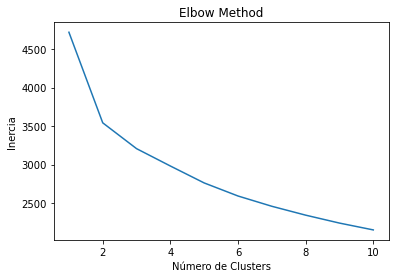

In [210]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=10, random_state=0)
    kmeans.fit(caract_normal)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.show()

Se elige un valor de 3 clusters para el enttrenamiento del modelo.

In [217]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(caract_normal)

In [218]:
clases = pd.DataFrame(kmeans.labels_)
clases_df = pd.concat((K_df,clases),axis=1)
clases_df = clases_df.rename({0:'clases'},axis=1)
clases_df

,Departamento,Dia,Hora,Zona,Clase_de_sitio,Arma,Movil_agresor,Movil_victima,Edad,Sexo,Estado_civil,Pais_de_nacimiento,Clase_de_empleado,Esolaridad,clases
0,1,2,14,1,17,2,1,1,28,1,5,3,20,4,0
1,1,2,23,1,108,1,1,1,49,1,4,3,6,1,1
2,1,2,10,1,108,2,1,1,36,1,1,3,12,4,1
3,1,2,16,1,108,2,1,1,31,1,4,3,6,4,1
4,1,2,0,1,108,2,1,1,18,1,4,3,10,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4960,22,4,19,0,108,1,1,4,76,1,1,3,12,4,1
4961,22,4,7,1,108,2,1,1,53,0,5,3,12,4,0
4962,22,4,18,0,108,2,1,1,33,1,1,3,12,4,1
4963,22,4,22,0,92,2,1,1,49,1,5,3,1,4,1


Finalmente se pueden visualizar las differentes gráficas comparando diferenesmétriccas que permien hae una segmenaión mejo de los criminales al momento de perfilarlos. Proceso que podría aún definir la probabilidad que tiene un ex convicto de reincidir de acuerdo a su perfil. 

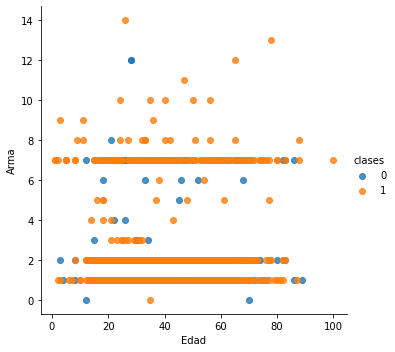

In [219]:
sn.lmplot(x='Edad',y='Arma',data=clases_df,hue='clases',fit_reg=False)

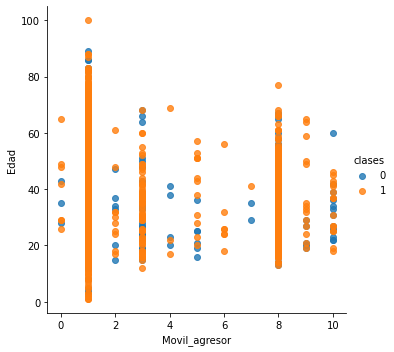

In [220]:
sn.lmplot(x='Movil_agresor',y='Edad',data=clases_df,hue='clases',fit_reg=False)

***Quinto Punto***

Un método propuesto parra haccer el despliegue, podría contarr con una aplicación web, que conectada a la nube puede obtene infomaión demográfica, y personal de criminales que pemita enena un modelo robusto capaz de perfila posibles reincidentes, o la posibilidad de genea políticas sociales y de seguidad más fuertes basados en los perfiles de pasados agesores para combatir el delito.

La segmentación podría ampliarse a la geneaión de mapas de alo on datos geográficos para poder pedecir la ocurrencia de crimenes focalizados en ciertas zonas y en cciertos días y fanjas horarias.
